In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import corner
import h5py
import lal
import pystan
import scipy.linalg as sl
import scipy.signal as sig
import scipy.stats as ss
import seaborn as sns
import qnm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

INFO:root:Could not load Schw QNM dict from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/schwarzschild/data/Schw_dict.pickle


In [4]:
ra = 1.95
dec = -1.27
psi = 0.82

tgps_H = 1126259462.423

dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))
dt_L = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['L1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))

tgps_L = tgps_H - dt_H + dt_L

gmst = lal.GreenwichMeanSiderealTime(lal.LIGOTimeGPS(tgps_H))
FpH, FcH = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['H1'].response, ra, dec, psi, gmst)
FpL, FcL = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['L1'].response, ra, dec, psi, gmst)

In [5]:
FpH, FcH, FpL, FcL

(0.5787432123814908,
 -0.4509465159486486,
 -0.5274337839186076,
 0.20520844606870395)

In [6]:
with h5py.File('H-H1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Hstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Hts = linspace(T0, T0+32-1.0/4096, Hstrain.shape[0])

with h5py.File('L-L1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Lstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Lts = linspace(T0, T0+32-1/4096, Lstrain.shape[0])
    
fny = 1.0/(Hts[1]-Hts[0])/2.0

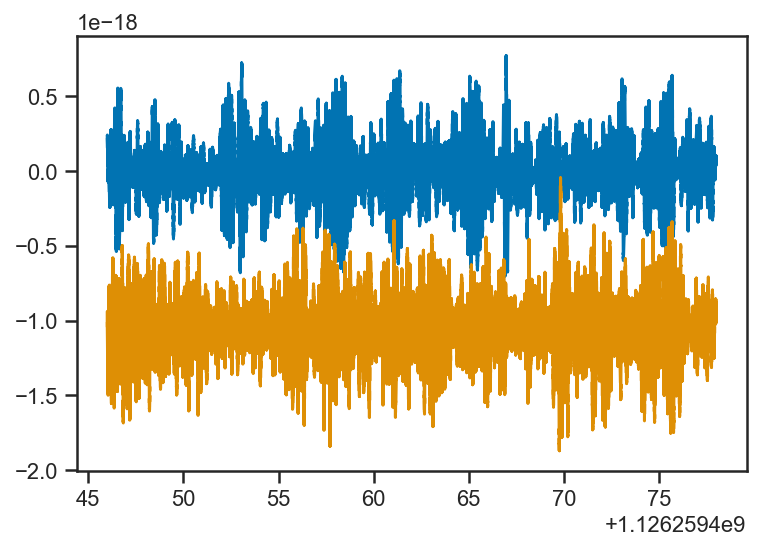

In [7]:
plot(Hts, Hstrain, label='H')
plot(Lts, Lstrain, label='L')

In [9]:
b, a = sig.butter(4, 20/fny, btype='highpass', output='ba')
Hfilt = sig.filtfilt(b, a, Hstrain)
Lfilt = sig.filtfilt(b, a, Lstrain)
Htsfilt = Hts
Ltsfilt = Lts

# Grab the first sample that is *after* the merger in both detectors
I0H = where(tgps_H <= Htsfilt)[0][0]
I0L = where(tgps_L <= Ltsfilt)[0][0]

Nanalyze = 128
Tanalyze = Nanalyze*(Htsfilt[1]-Htsfilt[0])
print('Will analyze {:.3f} s of data'.format(Tanalyze))

Will analyze 0.031 s of data


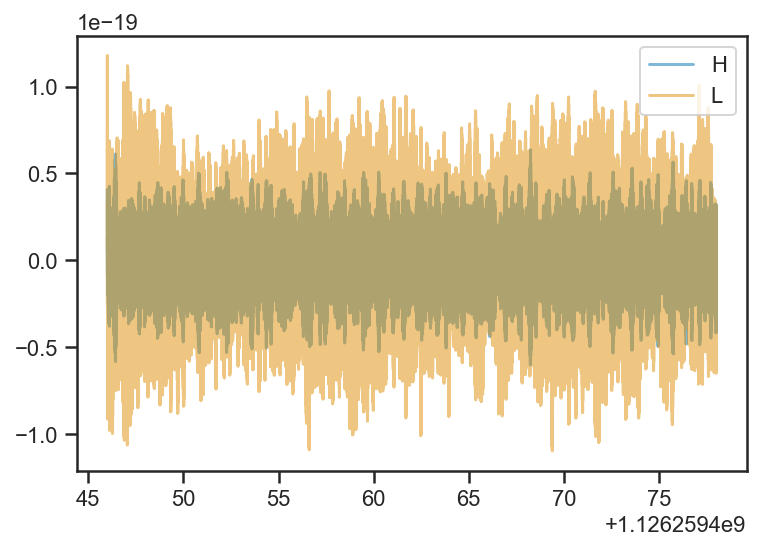

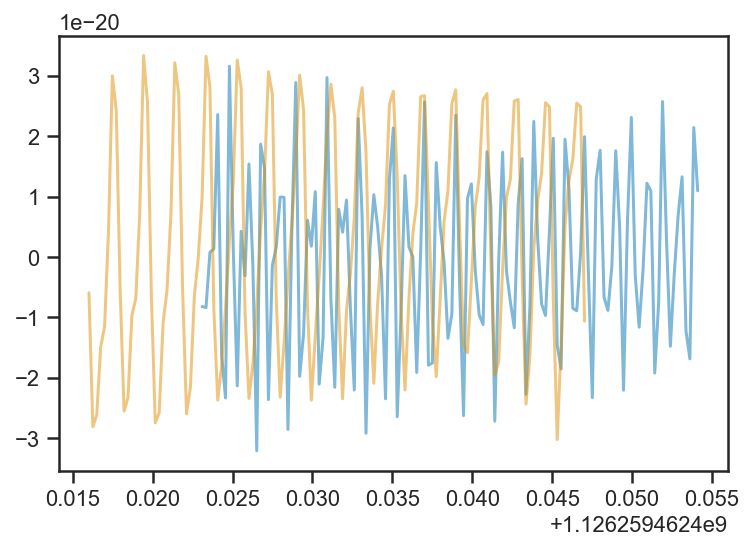

In [10]:
plot(Htsfilt, Hfilt, label='H', alpha=0.5)
plot(Ltsfilt, Lfilt, label='L', alpha=0.5)

legend(loc='best')

figure()
plot(Htsfilt[I0H:I0H+Nanalyze], Hfilt[I0H:I0H+Nanalyze], label='H', alpha=0.5)
plot(Ltsfilt[I0L:I0L+Nanalyze], Lfilt[I0L:I0L+Nanalyze], label='L', alpha=0.5)

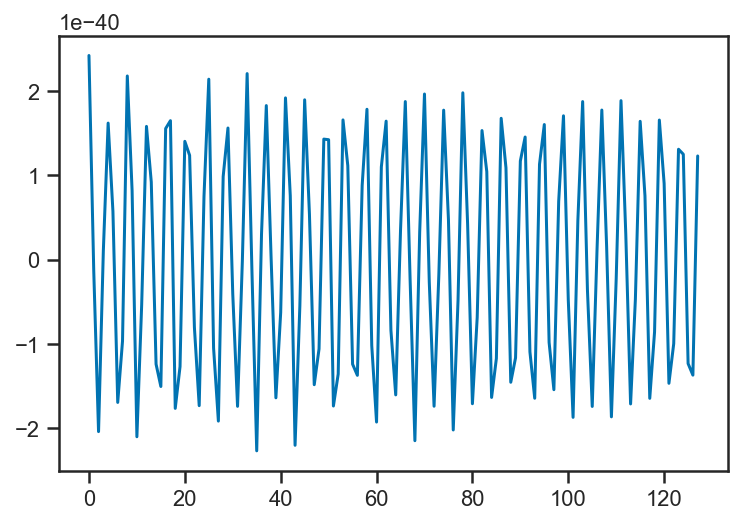

In [11]:
Hrho = sig.correlate(Hfilt, Hfilt)/Hfilt.shape[0]
Hrho = ifftshift(Hrho)
plot(Hrho[:Nanalyze])

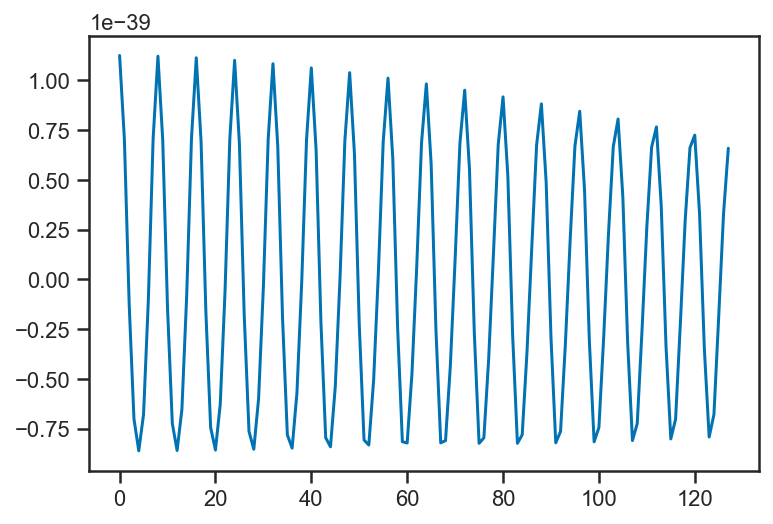

In [12]:
Lrho = sig.correlate(Lfilt, Lfilt)/Lfilt.shape[0]
Lrho = ifftshift(Lrho)
plot(Lrho[:Nanalyze])

In [13]:
HC = sl.toeplitz(Hrho[:Nanalyze])
HCorr = sl.toeplitz(HC[0,:]/HC[0,0])
HL = np.linalg.cholesky(HC)
HCorrL = np.linalg.cholesky(HCorr)

LC = sl.toeplitz(Lrho[:Nanalyze])
LCorr = sl.toeplitz(LC[0,:]/LC[0,0])
LL = np.linalg.cholesky(LC)
LCorrL = np.linalg.cholesky(LCorr)

This is something like the GW150914 plot: whitened data, with L shifted and inverted.

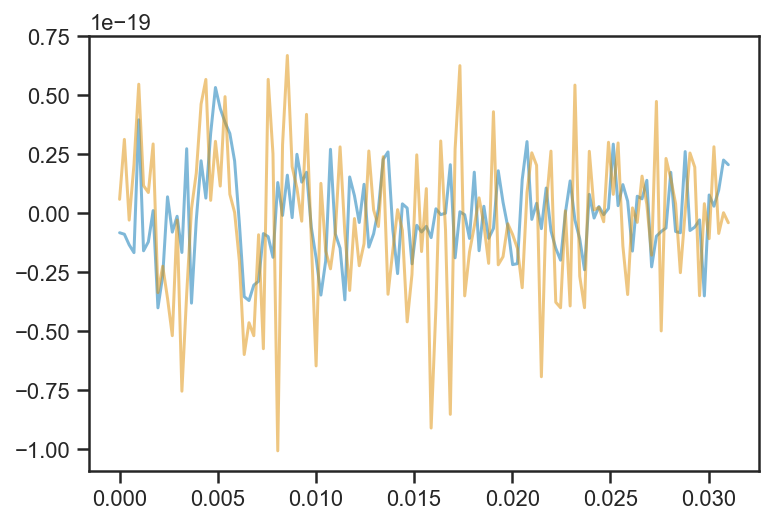

In [14]:
t = (Htsfilt[1]-Htsfilt[0])*arange(Nanalyze)
plot(t, np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), label='H', alpha=0.5)
plot(t, -np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), label='L', alpha=0.5)

In [15]:
x = randn(Nanalyze)
bHc = sl.cho_solve((HL, True), x)
bHt = sl.solve_toeplitz(Hrho[:Nanalyze], x)

In [16]:
x = randn(Nanalyze)
bLc = sl.cho_solve((LL, True), x)
bLt = sl.solve_toeplitz(Lrho[:Nanalyze], x)

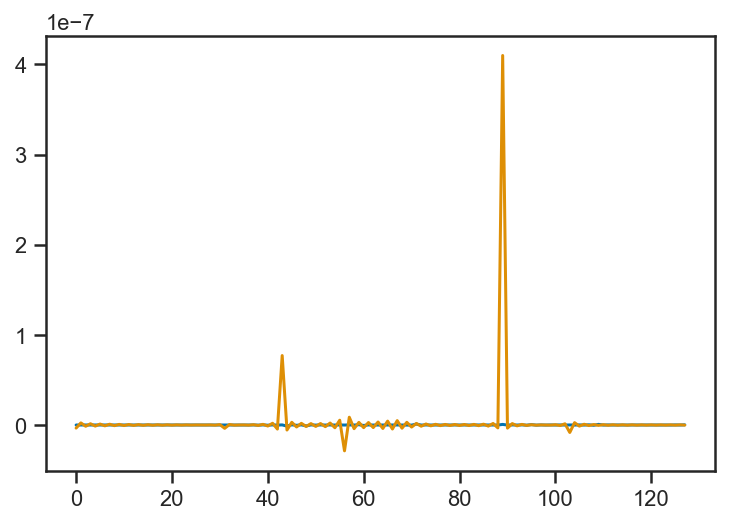

In [17]:
plot(2.0*(bHc-bHt)/(np.abs(bHc) + np.abs(bHt)))
plot(2.0*(bLc-bLt)/(np.abs(bLc) + np.abs(bLt)))

In [18]:
fref = 2.98e3 # Hz, at 68 MSun
chi0 = 0.69

g220 = qnm.modes_cache(-2, 2, 2, 0)
omega, _, _ = g220(a=chi0)
f0 = real(omega)/(2*pi) * fref
gamma0 = abs(imag(omega)) * fref

g221 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g221(a=chi0)
f1 = real(omega)/(2*pi) * fref
gamma1 = abs(imag(omega)) * fref

g222 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g222(a=chi0)
f2 = real(omega)/(2*pi) * fref
gamma2 = abs(imag(omega)) * fref

print('Given estimated tau0, expect signal to be down by exp(-{:.1f}) by end of data'.format(gamma0*Tanalyze))

INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n0.pickle
INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n0.pickle
INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n1.pickle
INFO:root:Loading Kerr QNM sequence from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/data/s-2_l2_m2_n1.pickle


Given estimated tau0, expect signal to be down by exp(-7.6) by end of data


In [19]:
model = pystan.StanModel(file='ringdown.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_baf2b07a0eddae95249d2f728f5f2888 NOW.
/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmph7t3bglc/stanfit4anon_model_baf2b07a0eddae95249d2f728f5f2888_5368197412709036931.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [20]:
data = {
    'nobs': 2,
    'nsamp': Nanalyze,
    'nmode': 2,
    
    't0': [tgps_H, tgps_L],
    'ts': [Htsfilt[I0H:I0H+Nanalyze], Ltsfilt[I0L:I0L+Nanalyze]],
    'strain': [Hfilt[I0H:I0H+Nanalyze], Lfilt[I0L:I0L+Nanalyze]],
    'L': [HL, LL],
    
    'mu_logf': [log(f0), log(f1)],#, log(f2)],
    'sigma_logf': [0.5, 0.5],#, 0.5],
    
    'mu_loggamma': [log(gamma0), log(gamma1)],#, log(gamma2)],
    'sigma_loggamma': [0.2, 0.2],#, 0.2],
    
    'FpFc': [[FpH, FcH], [FpL, FcL]],
    
    'Amax': 1e-19
}

In [21]:
n = 1
fit = model.sampling(data=data, iter=n*2000, thin=n)

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [22]:
fit = az.convert_to_inference_data(fit)

In [23]:
az.effective_sample_size(fit, var_names=['f', 'gamma', 'A', 'phi'])

<xarray.Dataset>
Dimensions:      (A_dim_0: 2, f_dim_0: 2, gamma_dim_0: 2, phi_dim_0: 2)
Coordinates:
  * phi_dim_0    (phi_dim_0) int64 0 1
  * gamma_dim_0  (gamma_dim_0) int64 0 1
  * A_dim_0      (A_dim_0) int64 0 1
  * f_dim_0      (f_dim_0) int64 0 1
Data variables:
    f            (f_dim_0) float64 482.4 991.0
    gamma        (gamma_dim_0) float64 1.304e+03 1.529e+03
    A            (A_dim_0) float64 1.064e+03 393.9
    phi          (phi_dim_0) float64 326.1 1.404e+03

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119318f60>,
      dtype=object)

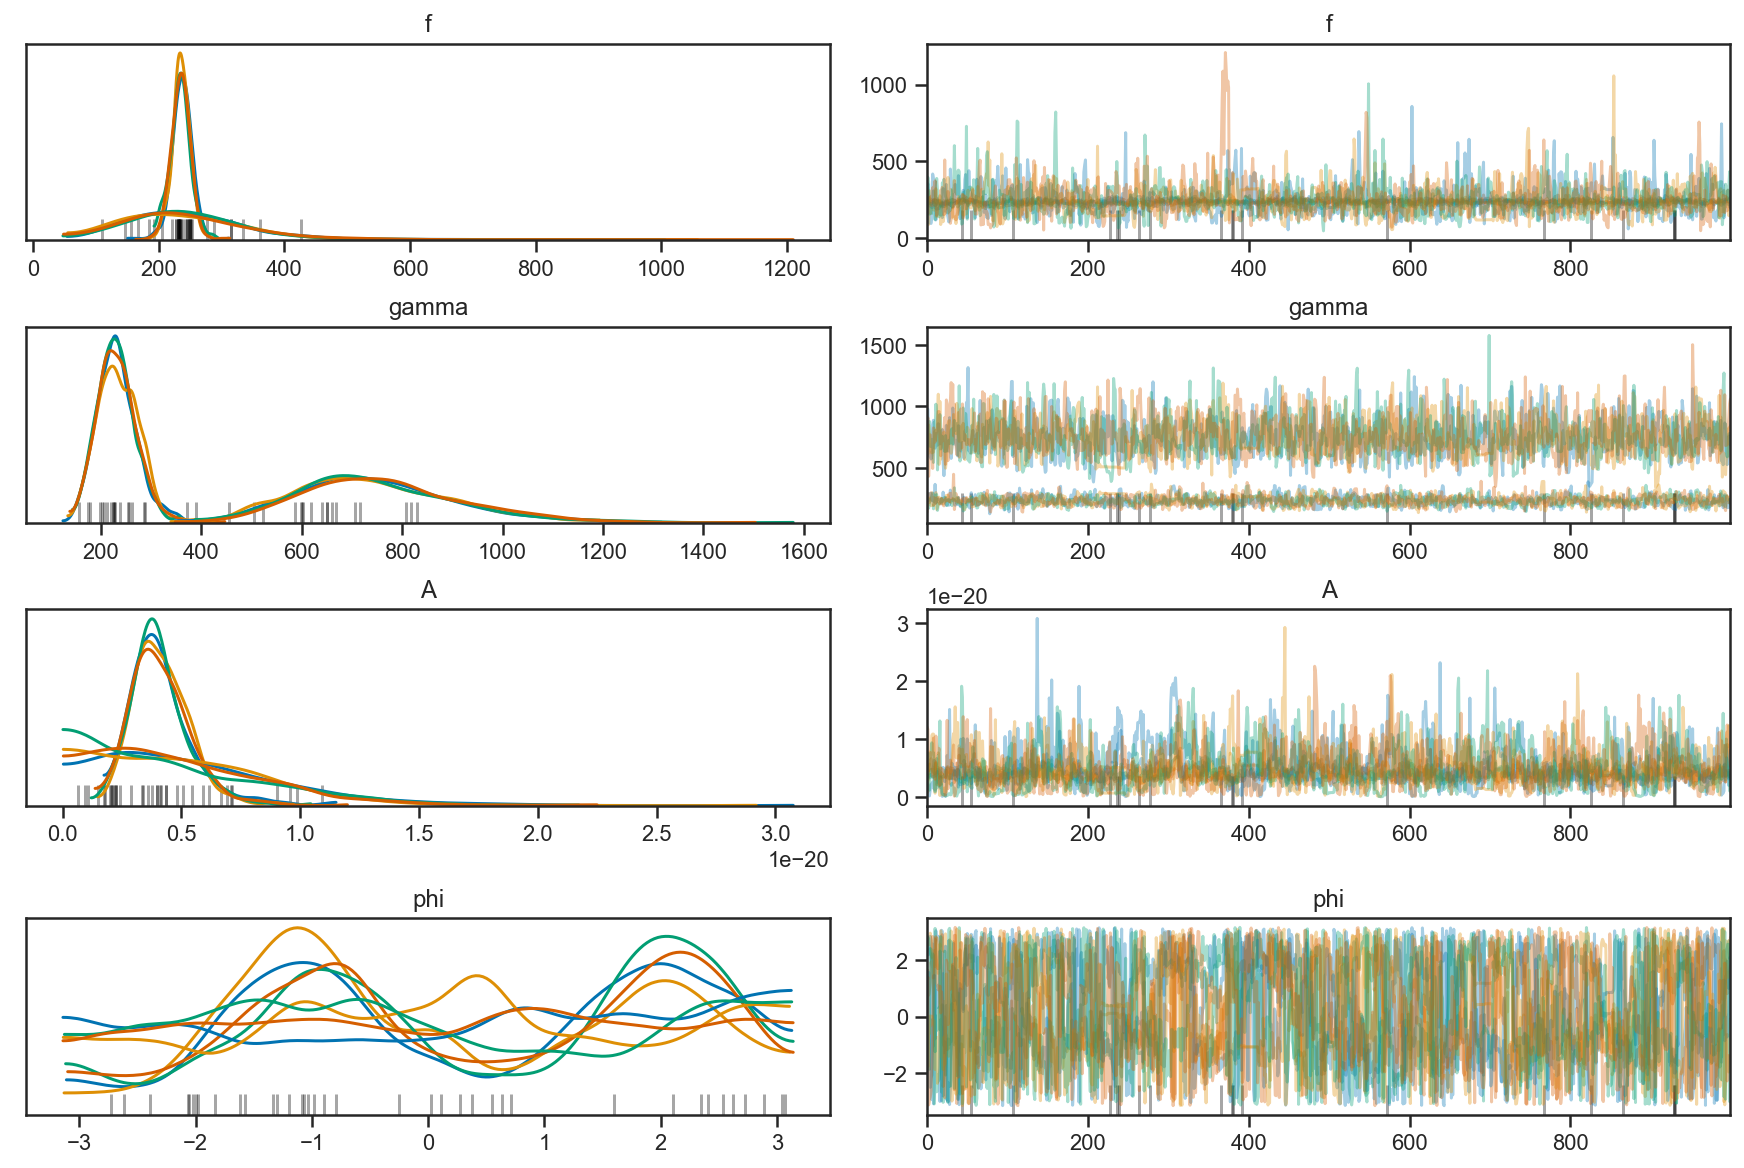

In [24]:
az.plot_trace(fit, var_names=['f', 'gamma', 'A', 'phi'], compact=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cd51898>,
      dtype=object)

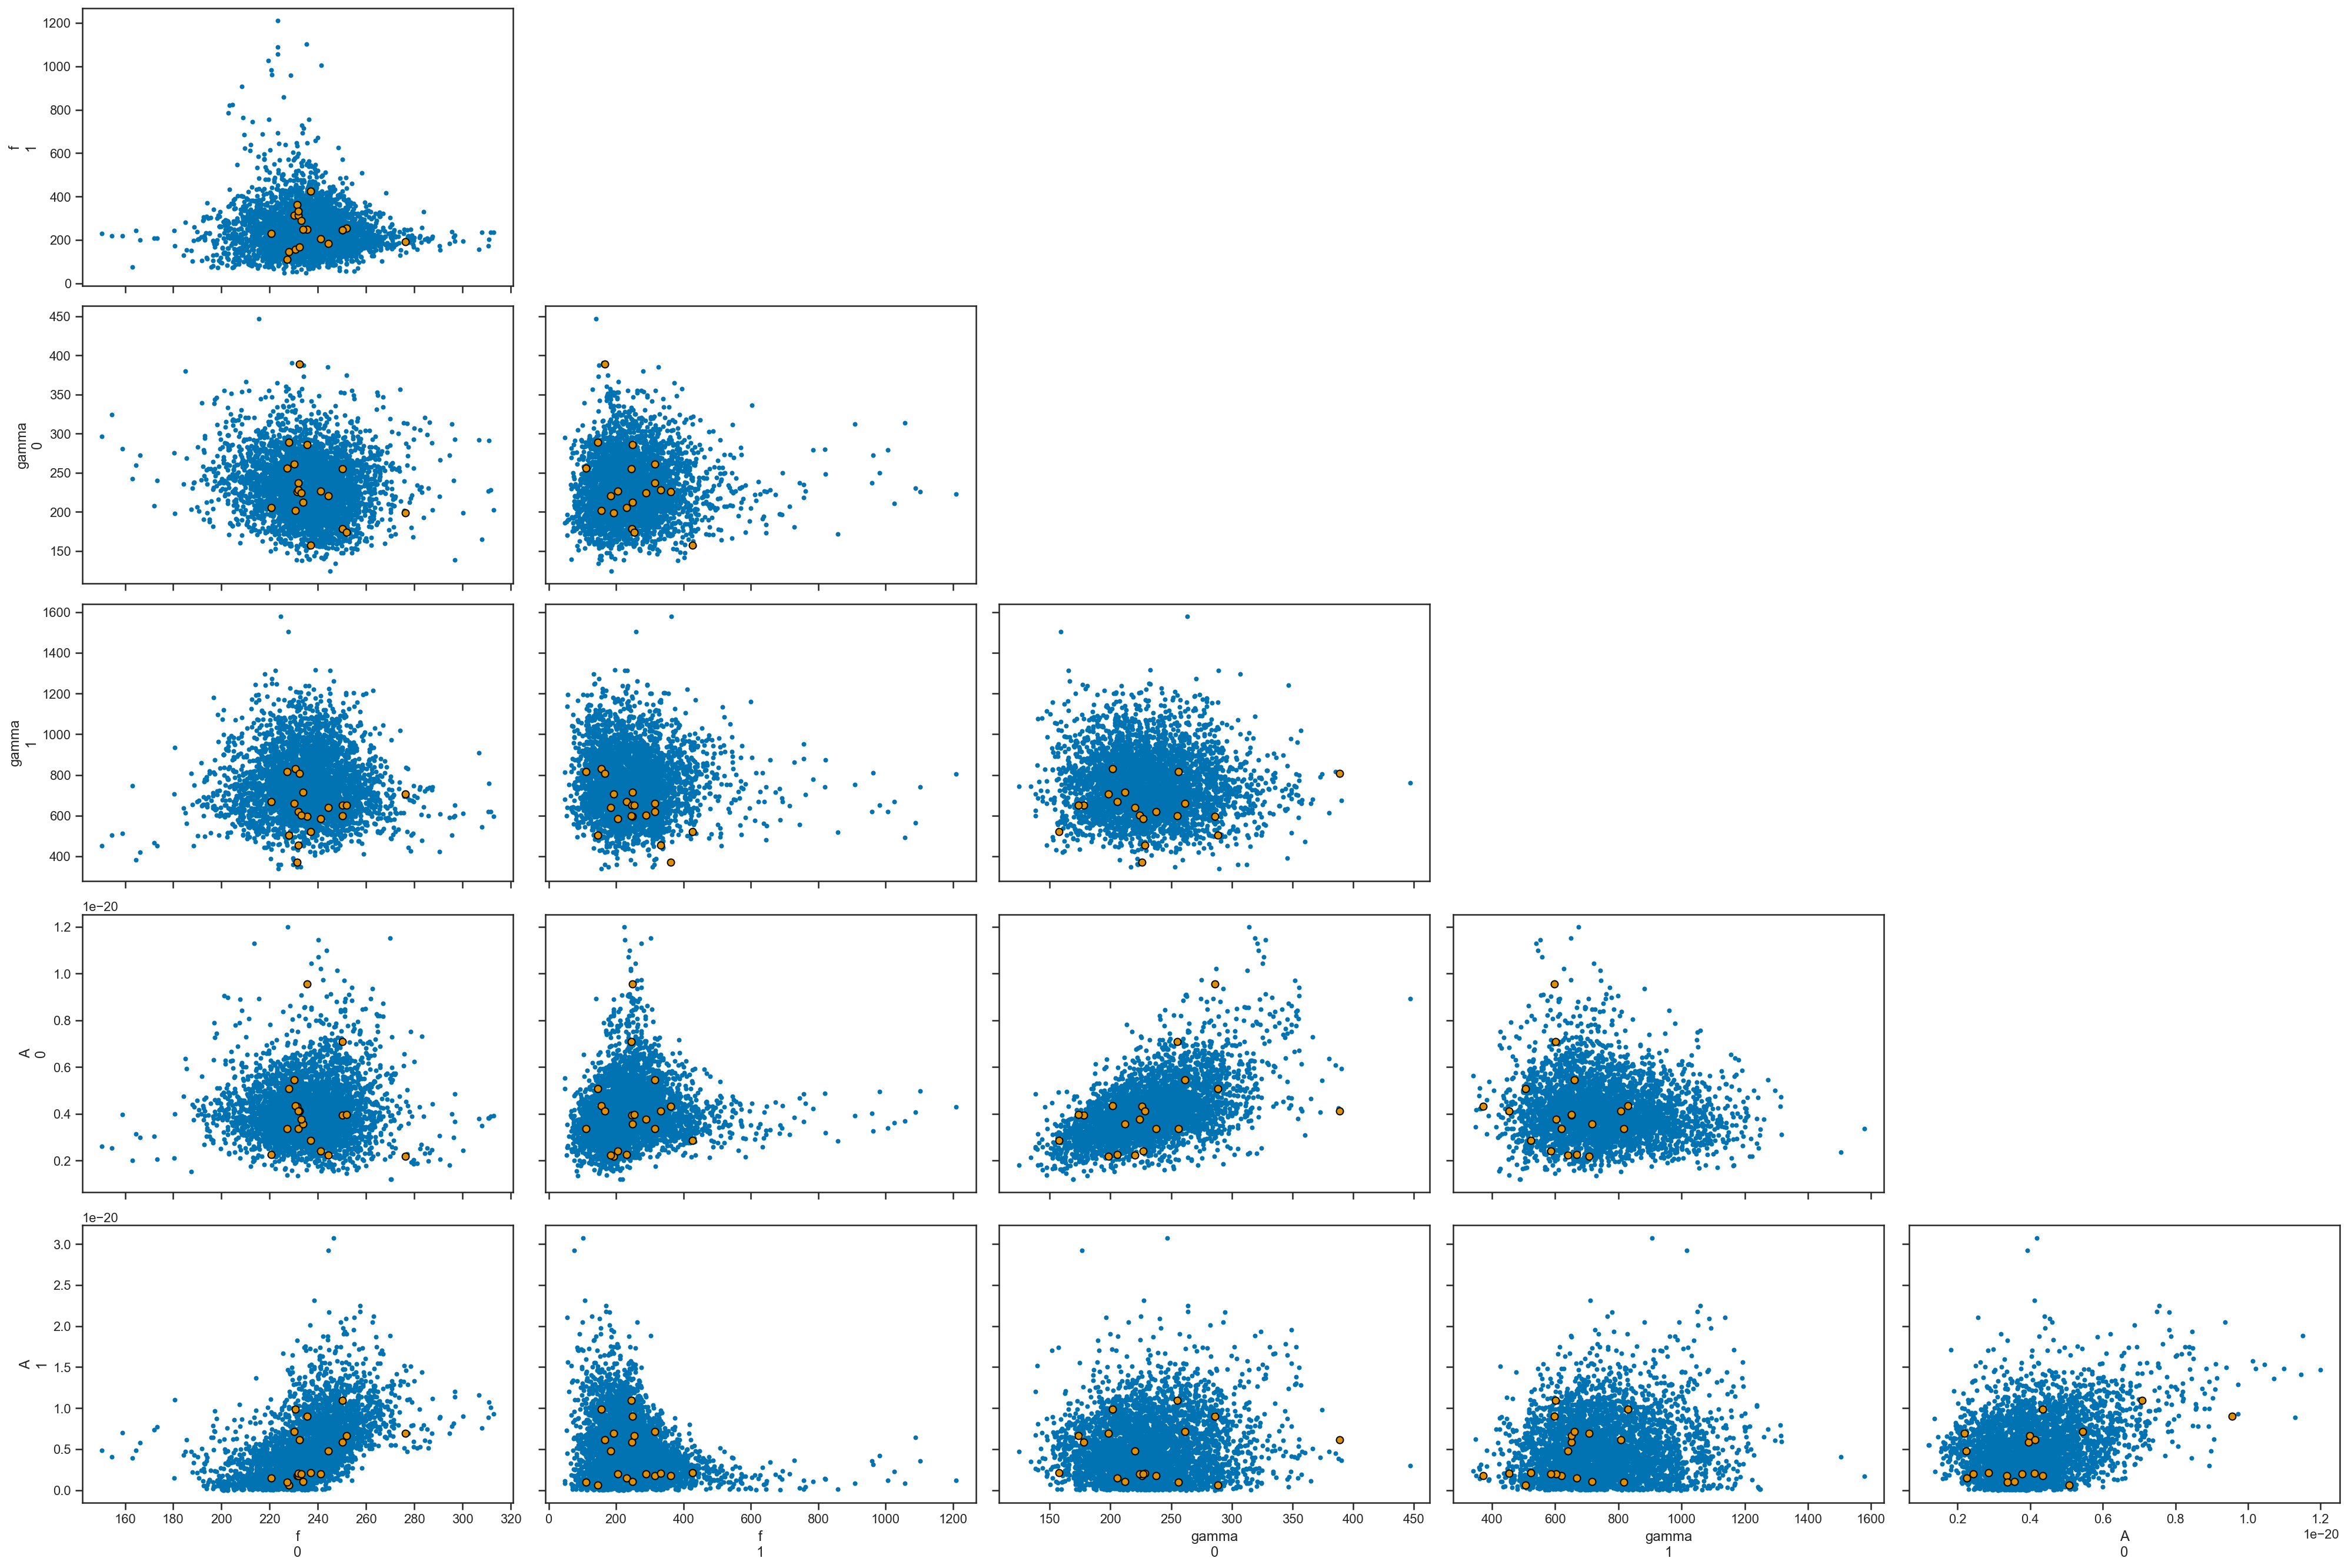

In [25]:
az.plot_pair(fit, var_names=['f', 'gamma', 'A'], divergences=True)

In [26]:
az.to_netcdf(fit, 'GW150914.nc')

'GW150914.nc'

In [27]:
mean(fit.posterior.f.values[:,:,0]), std(fit.posterior.f.values[:,:,0]), std(log(fit.posterior.f.values[:,:,0]))

(235.42364299088766, 15.745040344152555, 0.06762839152952214)

In [28]:
mean(fit.posterior.f.values[:,:,1]), std(fit.posterior.f.values[:,:,1]), std(log(fit.posterior.f.values[:,:,1]))

(246.84374007588224, 103.03473636741869, 0.394143541519661)

In [29]:
std(log(fit.posterior.f.values[:,:,0])), std(log(fit.posterior.gamma.values[:,:,0]))

(0.06762839152952214, 0.16640494464248526)

In [30]:
std(log(fit.posterior.f.values[:,:,1])), std(log(fit.posterior.gamma.values[:,:,1]))

(0.394143541519661, 0.20591284418016073)

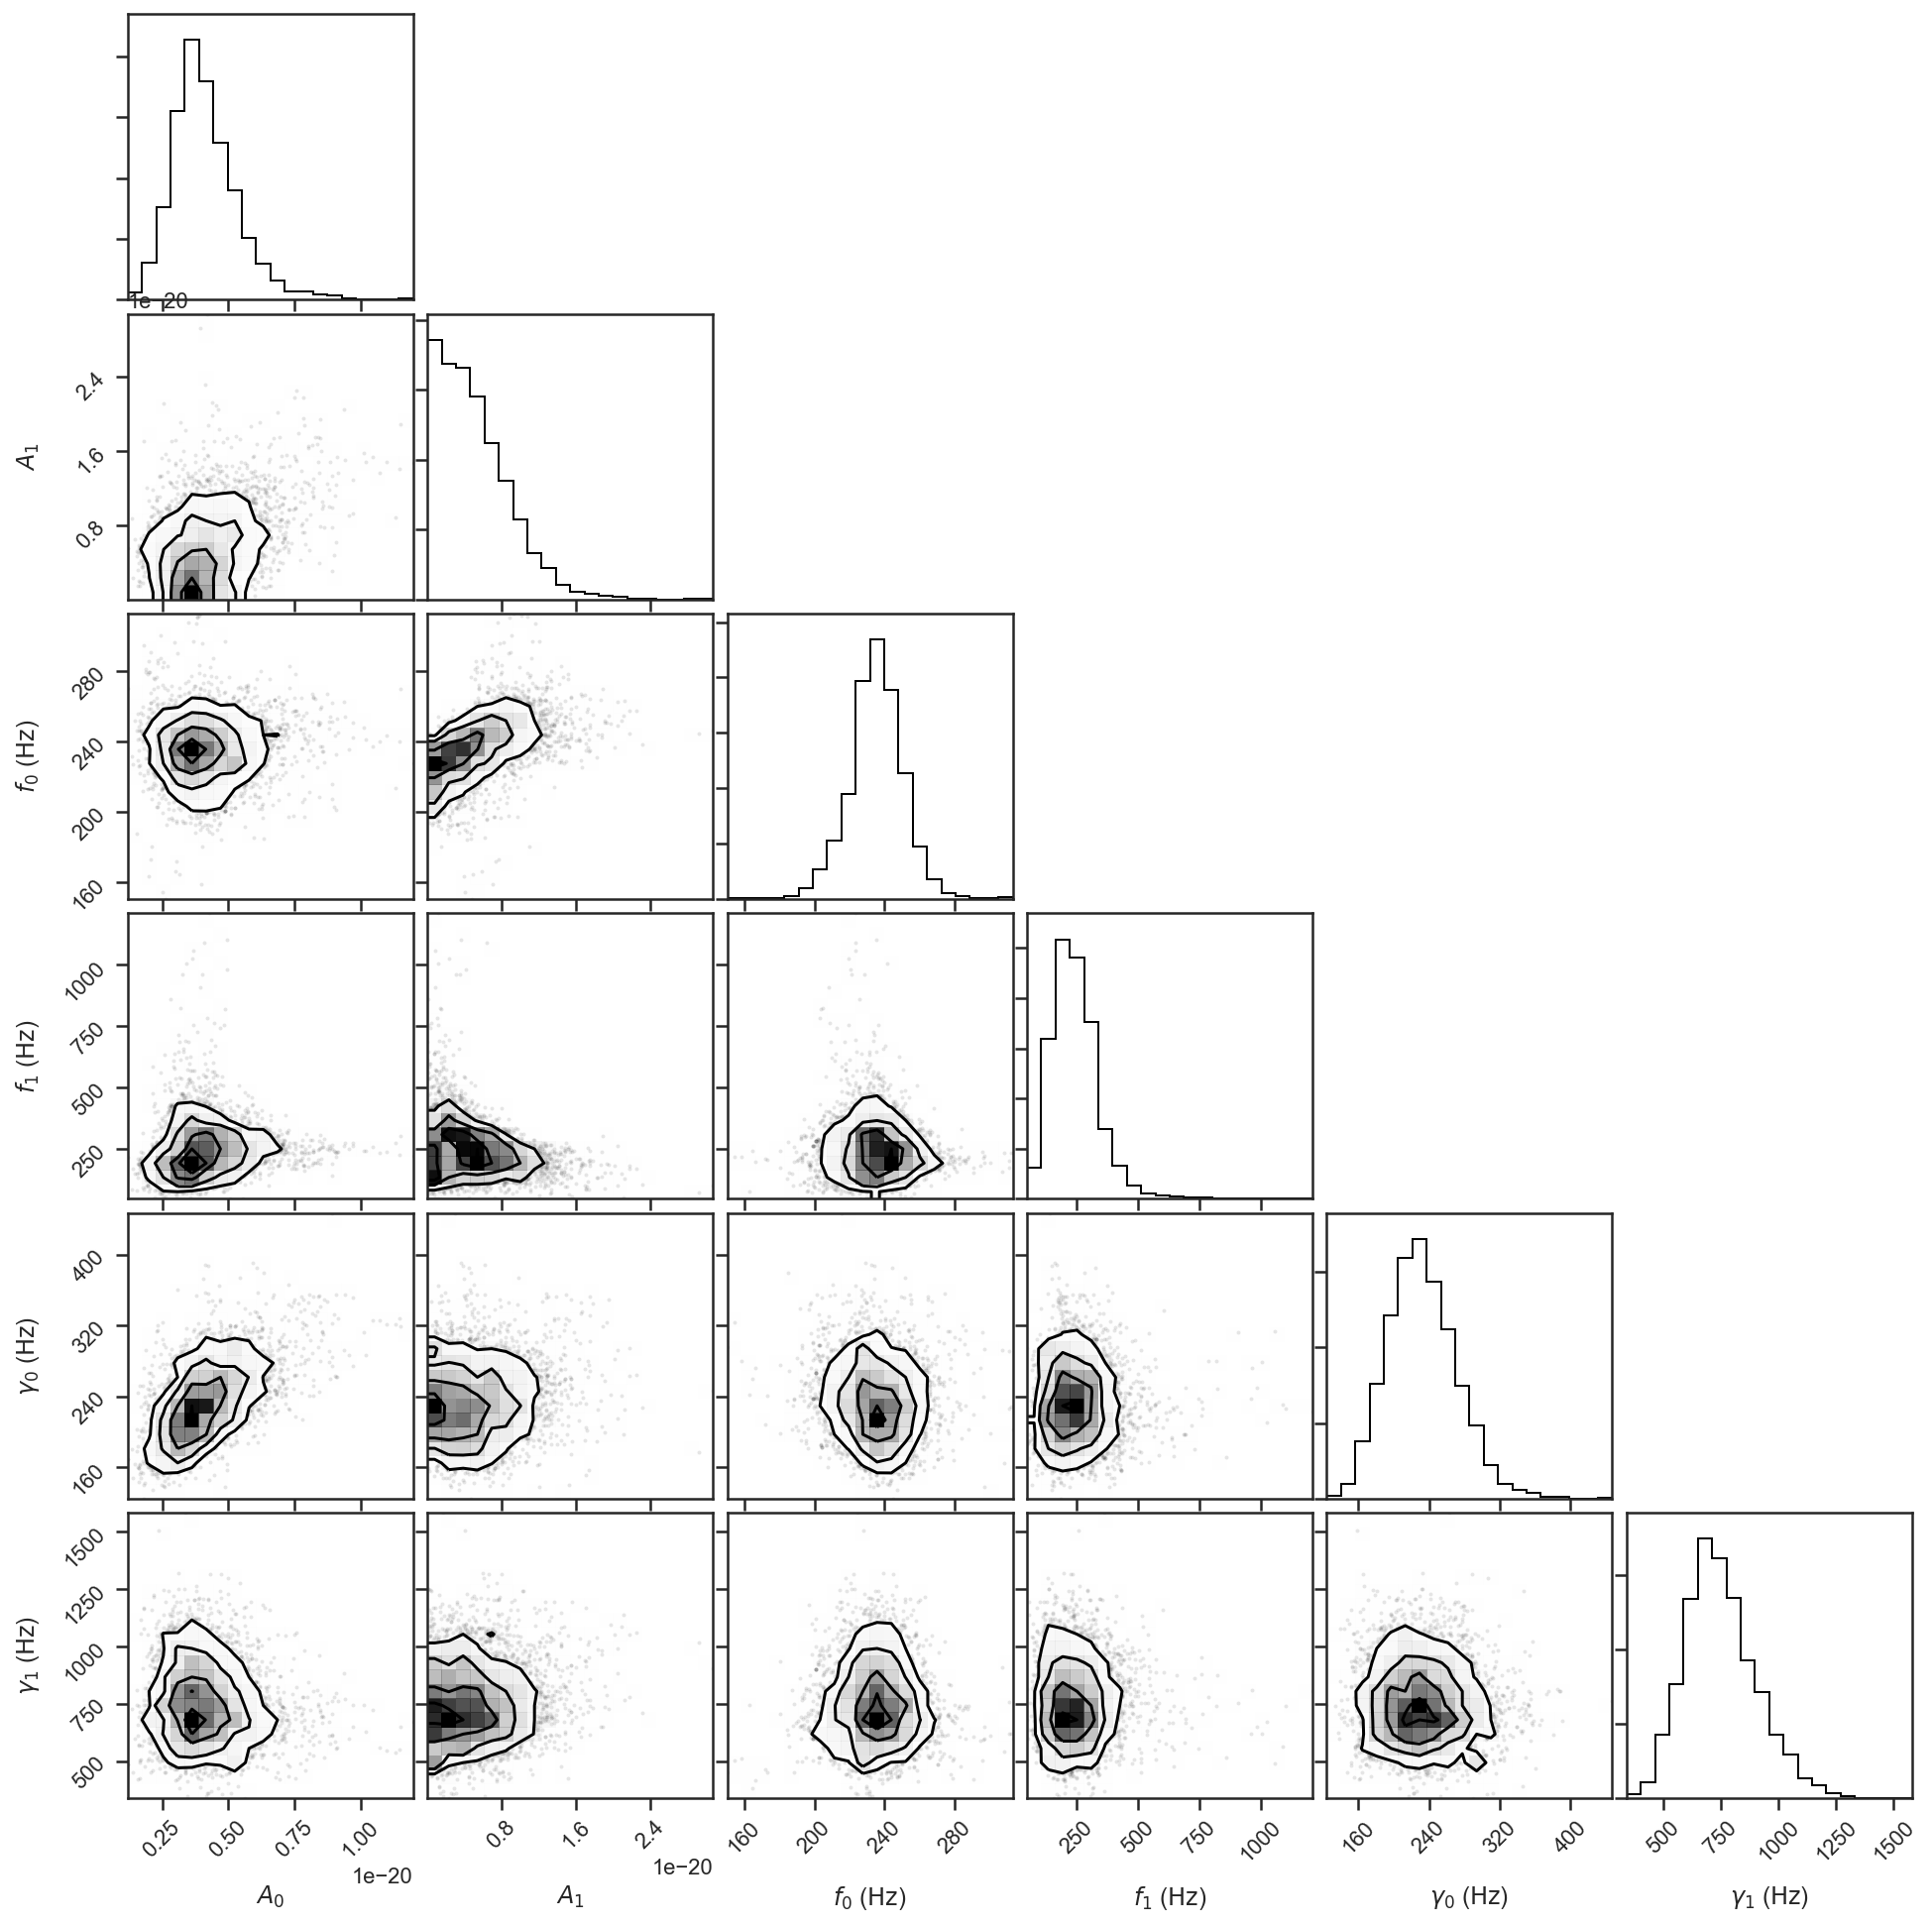

In [31]:
pts = column_stack((fit.posterior.A.values[:,:,0].flatten(), fit.posterior.A.values[:,:,1].flatten(),
                    fit.posterior.f.values[:,:,0].flatten(), fit.posterior.f.values[:,:,1].flatten(),
                    fit.posterior.gamma.values[:,:,0].flatten(), fit.posterior.gamma.values[:,:,1].flatten()))
names = [r'$A_0$', r'$A_1$',
         r'$f_0$ ($\mathrm{Hz}$)', r'$f_1$ ($\mathrm{Hz}$)',
         r'$\gamma_0$ ($\mathrm{Hz}$)', r'$\gamma_1$ ($\mathrm{Hz}$)']
corner.corner(pts, labels=names);

In [40]:
chis = linspace(0, 1, 100)[1:-1]

In [47]:
freqs0 = array([fref*real(g220(c)[0])/(2*pi) for c in chis])
freqs1 = array([fref*real(g221(c)[0])/(2*pi) for c in chis])

gams0 = array([fref*abs(imag(g220(c)[0])) for c in chis])
gams1 = array([fref*abs(imag(g221(c)[0])) for c in chis])

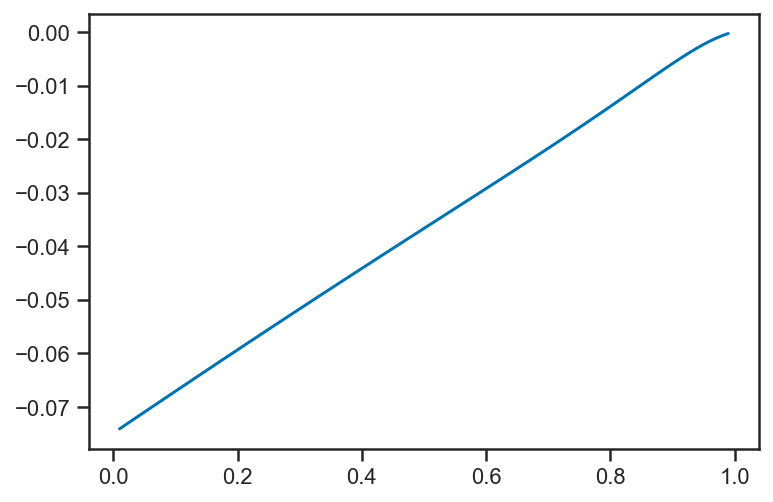

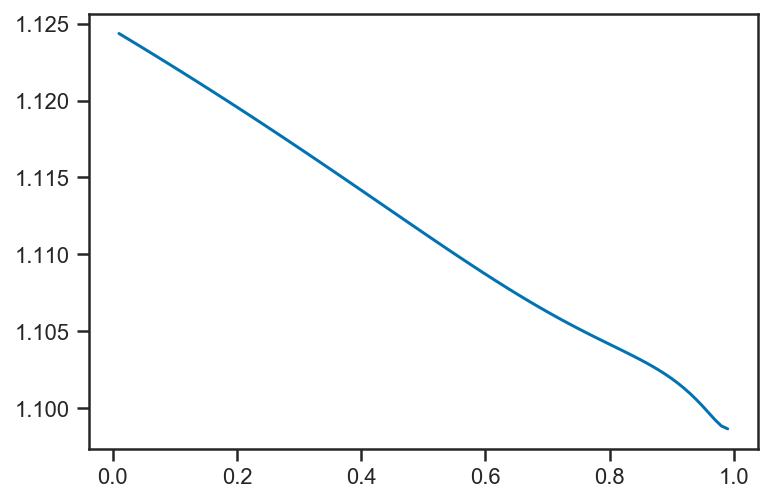

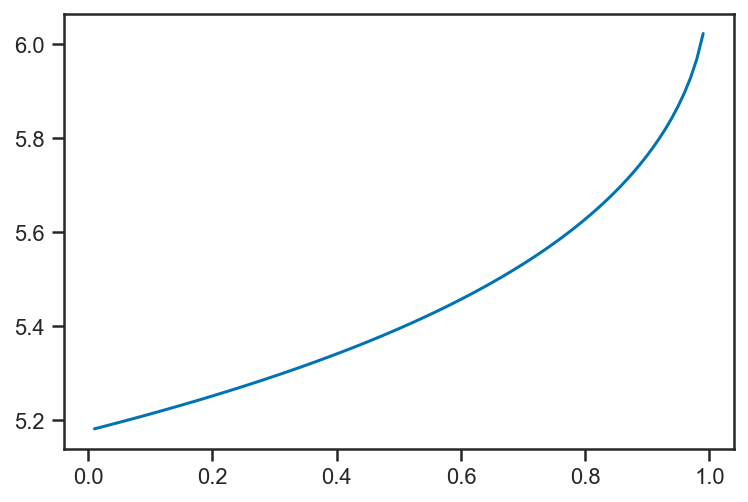

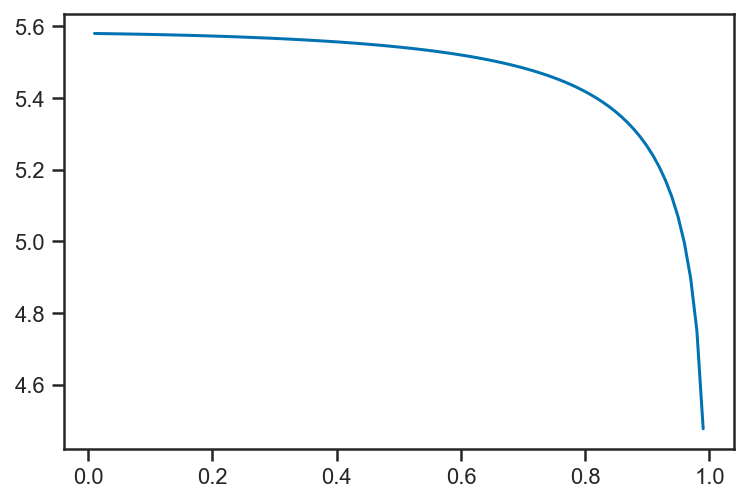

In [48]:
plot(chis, log(freqs1/freqs0))

figure()
plot(chis, log(gams1/gams0))

figure()
plot(chis, log(freqs0))

figure()
plot(chis, log(gams0))

0.4012937829601417

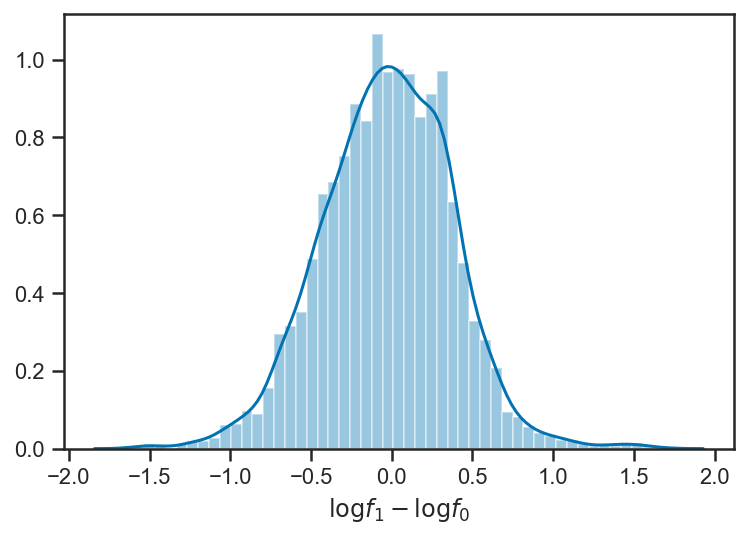

In [35]:
sns.distplot(log(fit.posterior.f.values[:,:,1].flatten()/fit.posterior.f.values[:,:,0].flatten()))
xlabel(r'$\log f_1 - \log f_0$')
std(log(fit.posterior.f.values[:,:,1].flatten()/fit.posterior.f.values[:,:,0].flatten()))

De-correlated:

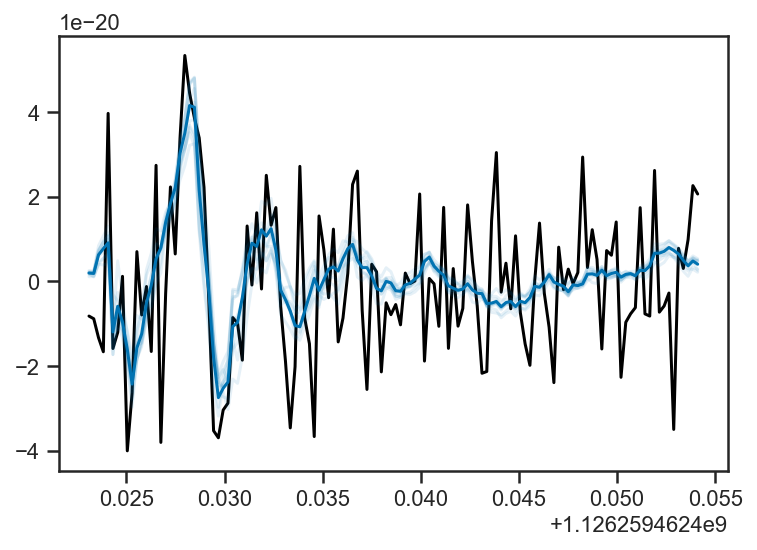

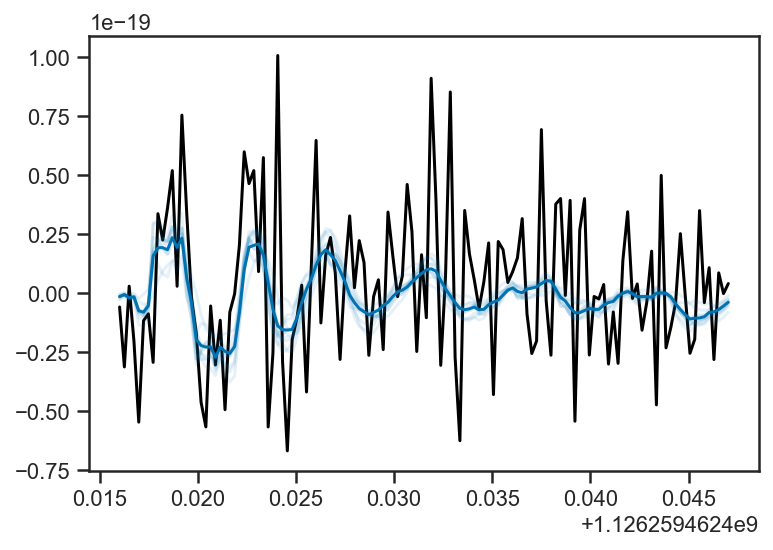

In [36]:
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), '-k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, mean(fit.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, fit.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)

figure()

plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), '-k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, mean(fit.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, fit.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)

Whitened:

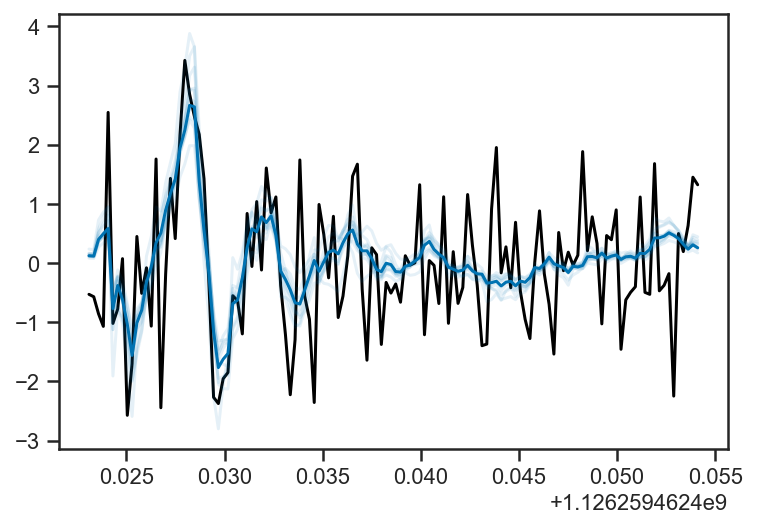

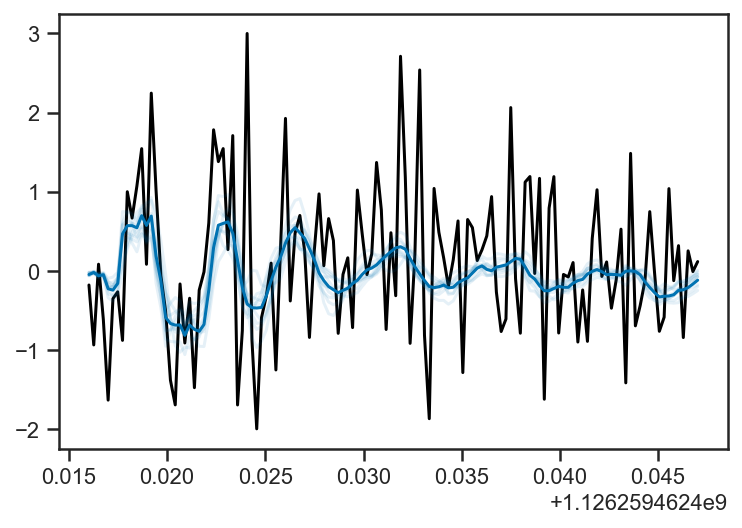

In [37]:
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), '-k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, mean(fit.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, fit.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)

figure()

plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), '-k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, mean(fit.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, fit.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)